In [1]:
### RUN EVERY TIME: COMTRADE DATASETS EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
import numpy as np
import gc
import os
import datetime
import time
import networkx as nx

In [3]:
### RUN EVERY TIME: VERSION CONTROL

from platform import python_version
print('python version: ', python_version())
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)

python version:  3.7.4
numpy version:  1.17.2
pandas version:  0.25.3


In [32]:
### RUN EVERY TIME: MAIN CONSTANTS

### MultiIndex level slice constant:
All = slice(None)
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### Dates:
str_date_end = '2022-12-31'
date_start = pd.Timestamp('1989-12-29')
date_end = pd.Timestamp(str_date_end)
date_ison = pd.Timestamp('1994-12-31')
### NA for MS Excel files:
list_na_excel_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null',
                        '#N/A Requesting Data...', '#N/A Invalid Security', '#N/A Field Not Applicable', '---']
### Checked EBOPS service IDs list (df_serv_to_gics['GICS Group Code']):
list_services = ['206', '210', '214', '218', '219', '223', '227', '231', '232', '237', '240', '246', '247', '250', '251', '254', '255', '256', '257', '258', '263',
                 '264', '269', '272', '273', '288', '289', '292', '293', '294', '310', '391', '431', '500', '888', '891', '892', '894', '950']
### Augmented bilateral export:
str_path_export_bilateral = 'Data_Files/Source_Files/comtrade_export_bilateral.h5'
### Export key:
str_key_unc_export = 'export_augmented'
### Augmented bilateral import:
str_path_import_bilateral = 'Data_Files/Source_Files/comtrade_import_bilateral.h5'
### Import key:
str_key_unc_import = 'import_augmented'
### Augmented bilateral import:
str_path_gdp = 'Data_Files/Source_Files/gdp_dataset.h5'
### Factor file:
str_path_pagerank_exp = 'Data_Files/Source_Files/comtrade_pagerank_sum.h5'
str_key_comtrade_factor = 'comtrade_factor'
str_path_factor_xlsx = 'Data_Files/Source_Files/comtrade_factor.xlsx'
str_path_factor_csv = 'Data_Files/Source_Files/comtrade_factor.csv'

In [5]:
### DEFINING WEIGHTED AVERAGE CALCULATOR

def weighted_average(ser_data, ser_weight = None, int_min_count = 0):
    ### Default output:
    num_result = np.NaN
    ### Checking for data presence:
    if (ser_data.count() > int_min_count):       
        ### Checking for weights dataset:
        if ser_weight is None:
            ### Calculating of simple average:
            num_result = np.nanmean(ser_data.values)
        else:
            ### Weights filtering:
            list_weight = ser_weight[ser_data.dropna().index].values
            ### Checking for weights presence:
            if np.nansum(list_weight):
                ### Data filtering:
                list_data = ser_data.dropna().values
                ### Weighted average calculating:
                num_result = np.nansum(list_data * list_weight) / np.nansum(list_weight)
    ### Results output:
    return num_result

In [6]:
### DEFINING COUNTRY CODES EXTRACTOR

def get_country_codes(use_local_copy = False):  
    ### In case if URL is unavailable:
    if (use_local_copy):
        url_country_code = 'Data_Files/Source_Files/countrycode.html'
    ### Online extraction:
    else:
        url_country_code = 'https://countrycode.org/'
    df_full_codes = pd.read_html(url_country_code, index_col = 'COUNTRY')[0]
    df_full_codes[['ISO SHORT', 'ISO LONG']] = df_full_codes['ISO CODES'].str.split(' / ', expand = True)
    df_result = df_full_codes[['ISO SHORT', 'ISO LONG']].sort_index()    
    df_result.index = df_result.index.str.upper()
    ### Results output:
    return df_result

In [7]:
### DEFINING EXTRACTION UNIVERSE DATA FROM MS EXCEL SOURCE (TO BE IGNORED IN PRODUCT CODE)

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(engine = 'openpyxl', io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                 na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [8]:
### RUN EVERY TIME: COMMON DATA EXTRACTION STEPS

### World Country Codes:
df_country_codes = get_country_codes()
### ISON membership history:
ser_ison_membership = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_end))
ser_ison_membership.index.names = ['Date', 'Reporter']
### ISON Members:
list_ison_countries = sorted(ser_ison_membership.index.get_level_values('Reporter').unique())
### ISON status for the last available date:
ser_ison_status = ser_ison_membership.loc[ser_ison_membership.index[-1][0]]

In [ ]:
### BILATERAL EXPORT DATA LOADING TO PERFORM FACTOR CALCULATION

gc.collect()
list_export_chunks = []
for num_iter_number, ser_iter_chunk in enumerate(pd.read_hdf(str_path_export_bilateral, key = str_key_unc_export, chunksize = 1000000)):
    gc.collect()
    print(num_iter_number, ': Extraction started')
    ser_iter_chunk = ser_iter_chunk[ser_iter_chunk > 0.0].astype('int32')
    df_iter_chunk = ser_iter_chunk.reset_index()
    df_iter_chunk = df_iter_chunk[(df_iter_chunk['Reporter'] != df_iter_chunk['Partner']) & \
                                  ((df_iter_chunk['Type'] == 'Goods') | df_iter_chunk['Commodity_ID'].isin(list_services)) & (df_iter_chunk['Reporter'] != 'World') & \
                                  (df_iter_chunk['Partner'] != 'World')]\
                               .drop('Type', axis = 1)    
    print(num_iter_number, ': Filtering performed')    
    ser_iter_chunk = df_iter_chunk.set_index(['Date', 'Reporter', 'Partner', 'Commodity_ID']).squeeze().sort_index()
    del df_iter_chunk
    gc.collect()
    list_export_chunks.append(ser_iter_chunk)
    print(num_iter_number, ': Chunk added to container')    
ser_bilateral_export = pd.concat(list_export_chunks, axis = 0, sort = False).sort_index()
ser_bilateral_export.name = 'Export'
del list_export_chunks
gc.collect()

In [22]:
### REPORTER / COMMODITY BY DATE TOTAL EXPORT & IMPORT & TRADE

gc.collect()
### Export totals:
ser_country_total_export = ser_bilateral_export.groupby(['Date', 'Reporter']).sum().dropna()
ser_country_total_export.name = 'Country_Total'
ser_country_total_weight = ser_country_total_export.groupby('Date').transform(lambda ser_group: ser_group / ser_group.sum())
ser_country_total_weight.name = 'Country_Weight'

In [10]:
### REPORTER / PARTNER BY DATE TOTAL EXPORT

gc.collect()
### Export totals:
ser_pair_total_export = ser_bilateral_export.groupby(['Date', 'Reporter', 'Partner']).sum().dropna()
ser_pair_total_export.name = 'Pair_Total'

In [24]:
### REPORTER / COMMODITY BY DATE PAGE RANK

gc.collect()
def get_pagerank(df_group):
    nx_graph = nx.from_pandas_edgelist(df_group, 'Reporter', 'Partner', edge_attr = 'Pair_Total', create_using = nx.DiGraph)
    dict_pagerank = nx.pagerank(nx_graph)
    ser_pagerank = pd.Series(dict_pagerank)
    return ser_pagerank
ser_total_pagerank = ser_pair_total_export.reset_index().groupby(['Date']).apply(get_pagerank)
ser_total_pagerank.name = 'Country_PG_Rank'
ser_total_pagerank.index.names = ['Date', 'Reporter']
ser_total_pagerank = ser_total_pagerank.sort_index()

<AxesSubplot:xlabel='Date'>

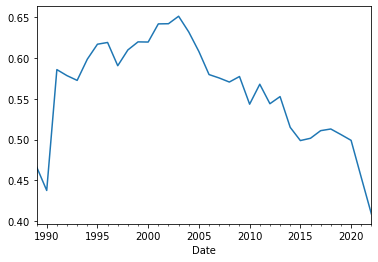

In [29]:
### TEMP

df_compare = pd.concat([ser_total_pagerank, ser_country_total_weight], axis = 1).loc[(All, ser_ison_status.index), :]
df_compare.groupby('Date').corr().loc[(All, 'Country_PG_Rank'), 'Country_Weight'].droplevel(-1).plot()

In [35]:
### PAGERANK FACTOR RESAMPLING

gc.collect()
### Resampling to monthly data:
def reindex_monthly(ser_group):
    ser_result = ser_group.droplevel(['Reporter']).reindex(pd.date_range(ser_group.index[0][0], str_date_end, freq = 'BY'))
    ser_result = ser_result.resample('BM').ffill()
    return ser_result
ser_pagerank_monthly = ser_total_pagerank.groupby('Reporter').apply(reindex_monthly).swaplevel()
ser_pagerank_monthly.index.names = ['Date', 'Reporter']
ser_pagerank_monthly.name = 'Pagerank_Factor'

In [37]:
### FACTOR SAVING

#ser_pagerank_monthly.to_excel(str_path_factor_xlsx, merge_cells = False)
ser_pagerank_monthly.to_csv(str_path_factor_csv, sep = ';', header = True)
ser_pagerank_monthly.to_hdf(str_path_pagerank_exp, str_key_comtrade_factor)